In [246]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from lifelines.utils import to_long_format
from scipy.signal import savgol_filter
from scipy import stats
from scipy.stats import chi2_contingency


In [205]:
watch=pd.read_excel('graph.xlsx',sheet_name=0)
pats=pd.read_excel('graph.xlsx',sheet_name=1)
outcome=pats[['PatientID','Depression Diagnosed During Study']]
outcome.columns=['PatientID','depression']

pats=pats.rename(columns={'Date Of MDD Diagnosis':'date'})
pats.date=pd.to_datetime(pats.date)
watch.DateTested=pd.to_datetime(watch.DateTested)
date=pats[['PatientID','date']]
watch=watch.merge(date, on='PatientID', how='left')
watch.date.fillna('2021-12-31',inplace=True)
watch.date=pd.to_datetime(watch.date)
watch=watch.loc[watch.DateTested<watch.date]

yesnodic={'yes':1,'no':0}
outcome=outcome.replace(yesnodic)
watch_rel=['PatientID',  'SleepTime', 'SPSleepTime', 'DeepSleep%', 'LightSleep%', 'pREM%', 'PAI', 'PAI-1', 'PAI-2', 'PAI-3', 'PAI-4', 'MeanPulserate', 'MaxPulserate', 'SleepLatency(min)', 'REMpLatency(min)', 'SleepEfficiency', 'NumberOfWakes']
watch_d=watch[watch_rel]

pat_thres=5
drop=True
if drop:
    gropued=watch_d.groupby('PatientID').count()
    good_pats=gropued.loc[gropued.SleepTime>pat_thres].index

new_depression=list(outcome.loc[outcome.depression==1].PatientID)
dysthimic=pats.loc[pats.Dysthimia=='yes'].PatientID
bipolar=pats.loc[pats['Bipolar Depression']=='yes'].PatientID
all_pats=list(outcome.PatientID)
sick=list(new_depression)+list(dysthimic)+list(bipolar)
clean = list(np.setdiff1d(all_pats,sick))



## WATCH DATA

FUNCTIONS

In [206]:
def drop_thresh(ser, thresh):
       return ser.loc[ser<thresh]

def last(ser):
    return (ser.iloc[-1])

def trend(ser):
    z = np.polyfit(range(len(ser)),ser,1)
    return z[0]*10

def count_thresh(ser, thres):
    return (ser.loc[ser<thres].count())/len(ser)

def first_under_thres(ser,thresh):
    ser=ser.reset_index(drop=True)
    count_thresh=ser.loc[ser<60].count()
    if count_thresh==0:
        return 1
    else:
        index=next(i for i,v in enumerate(ser) if (v<thresh))
        return index/len(ser)


In [207]:
ser=watch_d.loc[watch_d.PatientID=='RDS01']['REMpLatency(min)']
thresh=40


GROUPBY

In [212]:
drop=True
if drop:
    watch_d=watch_d.loc[watch_d['REMpLatency(min)']<200]

In [213]:
data=watch_d.groupby('PatientID').agg({
    'MeanPulserate':[lambda x: last(x),                                                  
                    lambda x:trend(x),
                    'mean'],
    'LightSleep%':[lambda x: last(x),                                                  
                    lambda x:trend(x),
                    'mean'],
    'pREM%':[lambda x: last(x),                                                  
                    lambda x:trend(x),
                    'mean'],
     'PAI':[lambda x: last(x),                                                  
                    lambda x:trend(x),
                    'mean'],
      'PAI':[lambda x: last(x),                                                  
                    lambda x:trend(x),
                    'mean'],
     'MeanPulserate':[lambda x: last(x),                                                  
                    lambda x:trend(x),
                    'mean'],   
     'SleepEfficiency':[lambda x: last(x),                                                  
                    lambda x:trend(x),
                    'mean'],
     'NumberOfWakes':[lambda x: last(x),                                                  
                    lambda x:trend(x),
                    'mean'],                                  
                 
    'REMpLatency(min)': [lambda x:last(x),
                         lambda x: trend(x),
                        lambda x: count_thresh(x,60),
                        lambda x:first_under_thres(x,60),
                        'mean']
                        }).reset_index()

In [214]:
data.columns = data.columns.map('_'.join).str.strip('|')



In [215]:
data.columns=[name.replace('<lambda_0>','last') for name in data.columns]
data.columns=[name.replace('<lambda_1>','trend') for name in data.columns]
data.columns=[name.replace('<lambda_2>','count_thresh') for name in data.columns]
data.columns=[name.replace('<lambda_3>','first_under_thresh') for name in data.columns]
data.columns=[name.replace('PatientID_','PatientID') for name in data.columns]
data.columns=[name.replace('REMpLatency(min)','REM_lat') for name in data.columns]

TABLE WITH WATCH DATA

In [319]:
data

,PatientID,MeanPulserate_last,MeanPulserate_trend,MeanPulserate_mean,LightSleep%_last,LightSleep%_trend,LightSleep%_mean,pREM%_last,pREM%_trend,pREM%_mean,PAI_last,PAI_trend,PAI_mean,SleepEfficiency_last,SleepEfficiency_trend,SleepEfficiency_mean,NumberOfWakes_last,NumberOfWakes_trend,NumberOfWakes_mean,REM_lat_last,REM_lat_trend,REM_lat_count_thresh,REM_lat_first_under_thresh,REM_lat_mean
0,RDS01,55,1.673913,58.041667,42.140,0.700665,54.648708,31.570,-0.640770,25.493875,79.3,-1.392609,53.920833,89.62,2.672130,88.916250,3,-0.321739,4.333333,85,-1.317391,0.416667,0.000000,72.791667
1,RDS02,70,1.909185,68.944444,92.577,6.515294,76.603444,7.415,-3.842332,15.982889,33.7,-2.058824,26.283333,70.97,-5.742105,80.905000,4,-0.815273,6.611111,44,-38.617131,0.111111,0.888889,118.333333
2,RDS03,91,40.000000,86.666667,59.546,-36.860000,62.371667,21.545,16.325000,22.047667,25.9,-0.500000,23.833333,83.55,-12.100000,83.463333,2,-15.000000,5.000000,139,285.000000,0.000000,1.000000,124.333333
3,RDS04,66,-8.545455,71.500000,64.608,-6.791091,77.865500,24.580,7.171636,13.205800,18.9,21.672727,15.500000,86.54,12.980000,78.473000,11,-11.333333,12.100000,85,-73.272727,0.000000,1.000000,123.700000
4,RDS08,63,-7.273913,66.708333,39.730,-8.712948,60.865250,33.456,1.744596,24.182875,76.1,35.910870,50.737500,91.32,6.000957,84.706667,3,-1.065217,5.791667,89,5.534783,0.000000,1.000000,129.708333
5,RDS09,47,-5.595238,47.125000,53.532,-5.185357,60.338125,24.499,-0.716190,23.334750,44.0,-1.571429,30.850000,82.65,-5.766667,85.652500,7,0.357143,6.375000,123,19.285714,0.000000,1.000000,100.250000
6,RDS10,69,4.214286,65.666667,42.506,-1.030500,51.924333,34.178,3.506464,27.097533,41.6,13.521429,26.373333,85.77,-4.562857,87.854667,6,0.678571,7.133333,49,0.285714,0.066667,0.933333,105.266667
7,RDS11,55,-0.610390,56.476190,48.912,-3.159740,66.573000,34.205,1.696948,18.403286,45.0,10.166234,22.680952,89.69,1.897532,83.570476,5,-0.571429,7.047619,113,-4.597403,0.000000,1.000000,112.714286
8,RDS12,67,-0.505983,65.615385,55.034,-2.237097,60.771654,28.520,1.151867,26.952115,32.3,-8.597949,49.934615,83.34,-0.201231,82.564615,14,0.885470,7.730769,60,-2.905983,0.538462,0.153846,72.153846
9,RDS13,43,-1.238390,42.888889,56.333,6.249174,56.598944,26.713,-5.715139,26.372611,13.5,4.782250,18.722222,85.87,-3.004850,87.796111,7,2.662539,6.222222,79,4.643963,0.055556,0.222222,117.222222


### DEMOG DATA

In [218]:
yesnodic={'yes':1,'no':0}
sexdic={'Female':1,'Male':0}
pats.replace(yesnodic,inplace=True)
pats.replace(sexdic,inplace=True)

In [219]:
rel_cols=['PatientID', 'Sex','Age','new OSA Diagnosed During Study', 'BZD', 'SSRI', 'SNRI', 'SGA', 'FGA',
          'NBZD', 'Lithium', 'NaSSA', 'TCA', 'Depalept', 'Lamotrigine', 'DNRI',           
          'Depression Diagnosed During Study', 'Bipolar Depression', 'Dysthimia', 
          'Cognitive Disorder', 'Panic Disorder','NUMBER OF PRIOR mdd EPISODES']
pat_d=pats[rel_cols]
pat_d=pat_d.rename(columns={'new OSA Diagnosed During Study':'OSA',
                            'Depression Diagnosed During Study':'Depression',
                            'NUMBER OF PRIOR mdd EPISODES':'mdd_episodes'
                      })
              

TABLE WITH DEMGORAPHOC DATA

In [320]:
pat_d

,PatientID,Sex,Age,OSA,BZD,SSRI,SNRI,SGA,FGA,NBZD,Lithium,NaSSA,TCA,Depalept,Lamotrigine,DNRI,Depression,Bipolar Depression,Dysthimia,Cognitive Disorder,Panic Disorder,mdd_episodes
0,RDS01,0,39,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,RDS02,1,59,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,4
2,RDS03,1,54,0,1,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,9
3,RDS04,1,53,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,6
4,RDS08,0,64,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5
5,RDS09,1,62,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,3
6,RDS10,1,57,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4
7,RDS11,1,62,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3
8,RDS12,0,49,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,3
9,RDS13,0,62,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2


## MERGE

In [220]:
merged=data.merge(pat_d, on='PatientID')

## UNIVARIATE

In [221]:
merged.set_index('PatientID', drop=True, inplace=True)

In [222]:
X=merged.drop('Depression', axis=1)
y=merged['Depression']

In [287]:
cat_cols=['Sex','OSA', 'BZD', 'SSRI', 'SNRI', 'SGA',  'NBZD', 'Lithium', 'NaSSA',
          'TCA', 'Depalept', 'Lamotrigine', 'DNRI', 'Bipolar Depression', 'Dysthimia',
          'Cognitive Disorder', 'Panic Disorder']
con_vars=list(np.setdiff1d(X.columns,cat_cols))


CONTINOUS

In [241]:
output = pd.DataFrame()


for var in con_vars:
    depres=merged.loc[merged.Depression==1][var]
    control=merged.loc[merged.Depression==0][var]
    d_mean=depres.mean().round(2)
    d_std=depres.std().round(2)
    c_mean=control.mean().round(2)
    c_std=control.std().round(2)
    pval=stats.ttest_ind(depres,control)[1].round(3)
    results={'variable':var,'depression':f'{d_mean}({d_std})','control':f'{c_mean}({c_std})','p_val':pval}
    output = output.append(results, ignore_index=True)


In [242]:
output.sort_values('p_val')

,variable,depression,control,p_val
21,mdd_episodes,6.17(2.04),3.71(1.86),0.017
22,pREM%_last,19.8(9.2),26.56(5.58),0.056
1,LightSleep%_last,67.11(16.73),56.03(8.99),0.067
23,pREM%_mean,19.01(5.2),22.86(3.52),0.068
2,LightSleep%_mean,68.43(11.49),61.97(4.37),0.079
4,MeanPulserate_last,70.17(13.29),62.21(10.22),0.161
5,MeanPulserate_mean,69.63(12.35),62.59(9.45),0.180
16,REM_lat_mean,113.34(19.96),99.35(23.08),0.214
11,PAI_mean,30.32(14.29),40.67(18.98),0.249
8,NumberOfWakes_mean,7.78(2.91),6.44(2.24),0.277


CATEGORICALTCA

In [297]:
output = pd.DataFrame()


for var in cat_cols:
    ct=pd.crosstab(merged[var], merged.Depression)
    pval=chi2_contingency(ct)[1].round(2)
    dep=round(ct.iloc[1,1]/(ct.iloc[1,1]+ct.iloc[0,1]),2)
    con=round(ct.iloc[1,0]/(ct.iloc[1,0]+ct.iloc[0,0]).round(2),2)
    results={'variable':var,'depression':f'{dep}','control':f'{con}','p_val':pval}
    output = output.append(results, ignore_index=True)



In [300]:
output.columns=['variable', 'depression (perecent positive)','control(percent positive)','p_val']
output.sort_values('p_val')

,variable,depression (perecent positive),control(percent positive),p_val
0,Sex,1.0,0.43,0.06
3,SSRI,0.83,0.29,0.08
4,SNRI,0.0,0.36,0.26
8,NaSSA,0.33,0.07,0.41
13,Bipolar Depression,0.0,0.21,0.58
9,TCA,0.17,0.0,0.65
2,BZD,0.5,0.71,0.68
5,SGA,0.5,0.36,0.92
1,OSA,0.17,0.14,1.00
6,NBZD,0.17,0.07,1.00


MULTIVARIATE

In [306]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [313]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [316]:
logisticRegr = LogisticRegression(max_iter=100)
logisticRegr.fit(X, y)
predictions = logisticRegr.predict(x_test)
score = logisticRegr.score(x_test, y_test)
print(score)

1.0


C:\JupyterLab\resources\jlab_server\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [318]:
y_test

PatientID
RDS5     0
RDS02    1
RDS6     0
RDS12    0
Name: Depression, dtype: int64

## PLOTTINg

In [150]:
pat_thres=5
drop=True
if drop:
    gropued=watch_d.groupby('PatientID').count()
    good_pats=gropued.loc[gropued.SleepTime>pat_thres].index

    merged=merged.loc[merged.PatientID.isin(good_pats)]

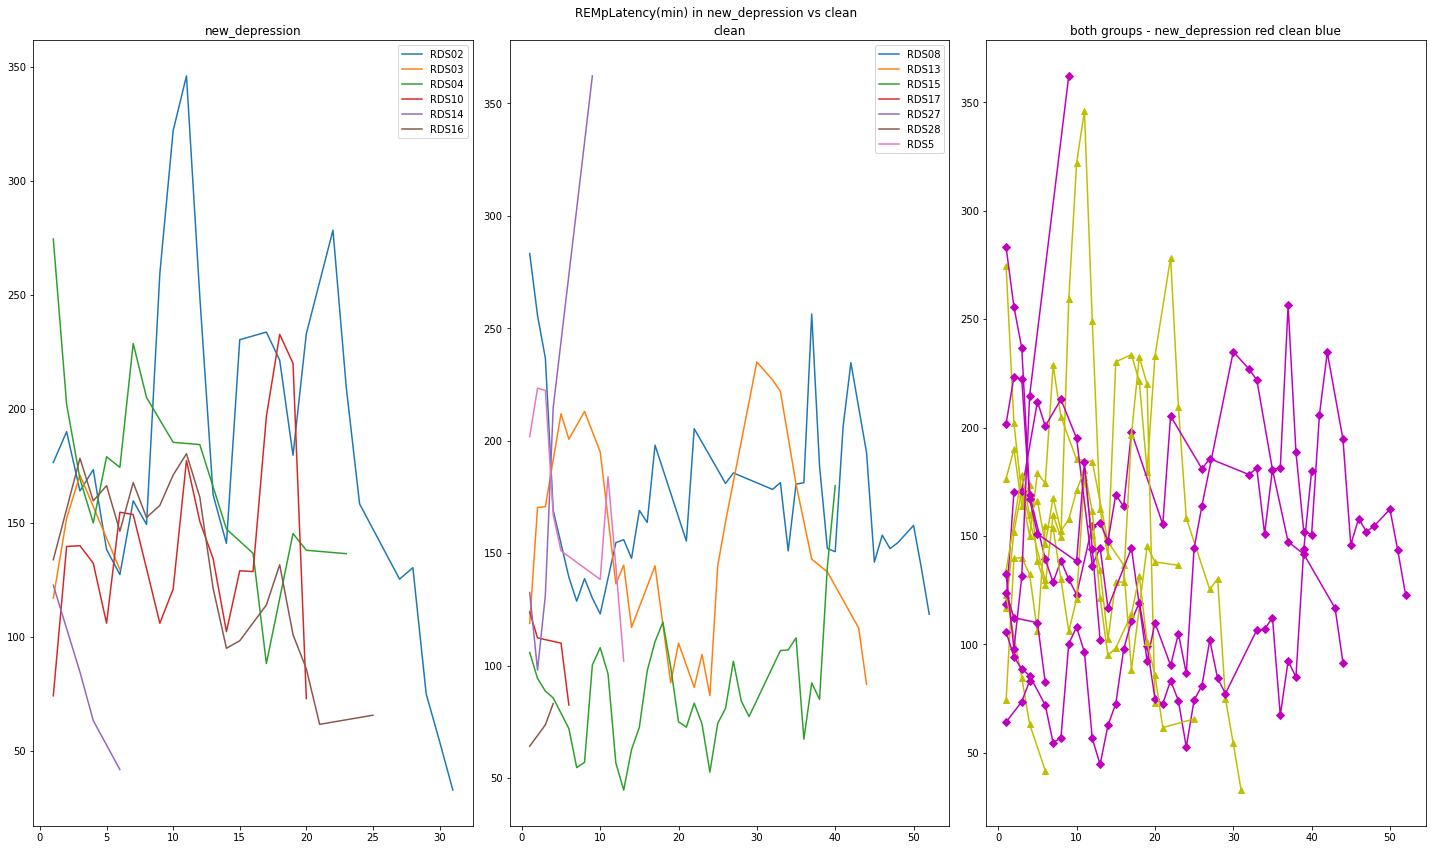

In [105]:

pat='RDS08'
var='REMpLatency(min)'
group1=new_depression
group1_name='new_depression'

group2=clean
group2_name='clean'


fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,12))

for pat in all_pats:
    data=watch.loc[watch.PatientID==pat]
    if pat in group1:
        x=data.WeeksInStudy
        y=data[var]
        
        yhat = savgol_filter(y, 3, 1) # window size 51, polynomial order 3
        ax1.plot(x,yhat)
        ax3.plot(x,yhat,'y-^')
    elif pat in group2:
        x=data.WeeksInStudy
        y=data[var]
        yhat = savgol_filter(y, 3, 1) # window size 51, polynomial order 3

        ax2.plot(x,yhat)
        ax3.plot(x,yhat,'m-D') 

    else:
        pass
    
ax1.set_title(group1_name)
ax1.legend(group1)
ax2.set_title(group2_name)
ax2.legend(group2)

ax3.set_title(f'both groups - {group1_name} red {group2_name} blue')
fig.suptitle(f'{var} in {group1_name} vs {group2_name}')

plt.tight_layout()
plt.show()

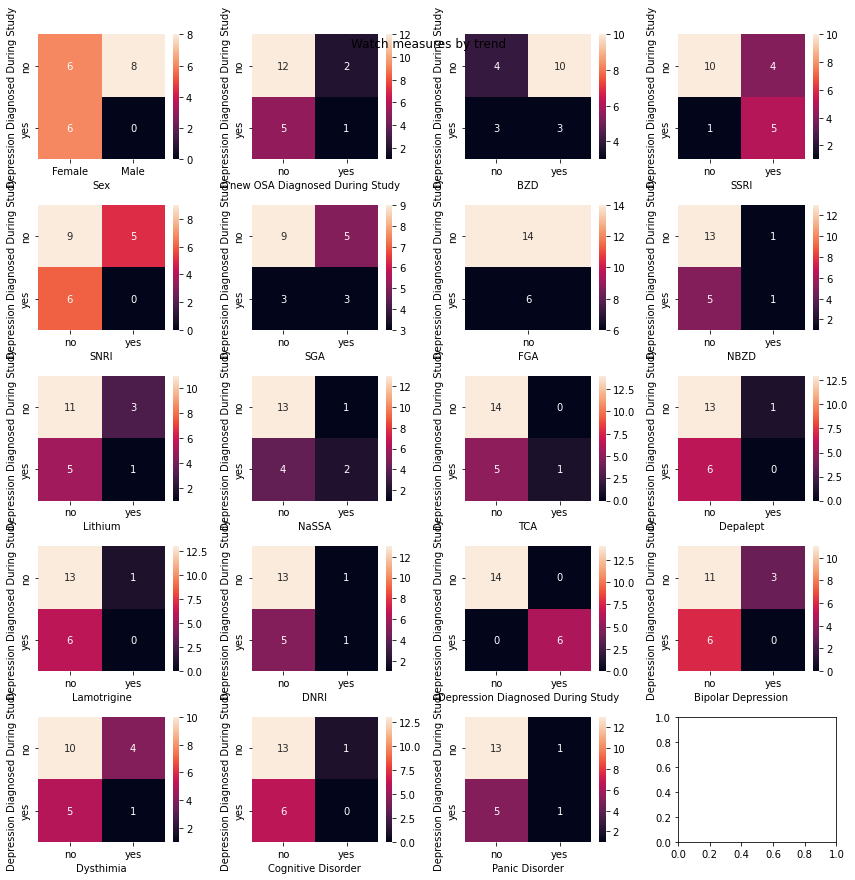

In [180]:
fig, axs = plt.subplots(5,4, figsize=(12,12))


for i,ax in enumerate(axs.flat):

    if i<19:
        col=cat_cols[i]
        cross=(pd.crosstab(pats['Depression Diagnosed During Study'], pats[col]))
        sns.heatmap(cross,annot=True,ax=ax)
    else:
        pass
    # Show the result
plt.tight_layout()
fig.suptitle('Watch measures by trend')
plt.show()

In [134]:

gropued=watch_d.groupby('PatientID').mean()
gropued=watch_d.groupby('PatientID').std()
gropued=watch_d.groupby('PatientID').agg(lambda x: trend(x))


C:\JupyterLab\resources\jlab_server\lib\site-packages\pandas\core\groupby\generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


In [136]:
merged=gropued.merge(outcome, on='PatientID')
merged.shape

(20, 16)

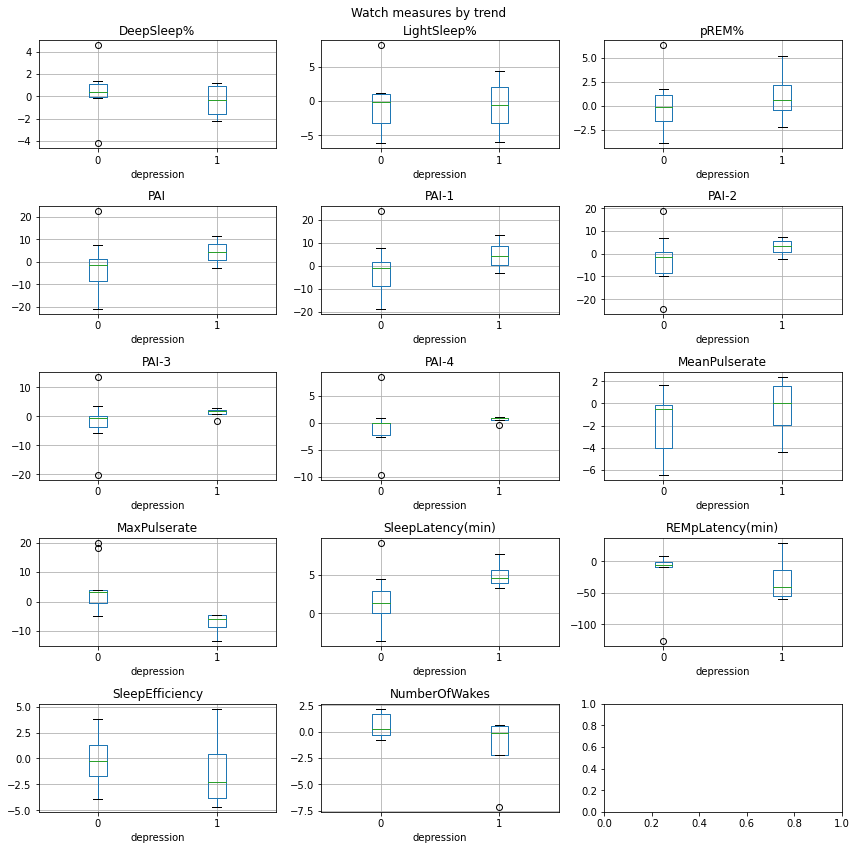

In [152]:
box_cols=[ 'DeepSleep%', 'LightSleep%', 'pREM%', 'PAI', 'PAI-1', 'PAI-2', 'PAI-3', 'PAI-4', 'MeanPulserate', 'MaxPulserate', 'SleepLatency(min)', 'REMpLatency(min)', 'SleepEfficiency', 'NumberOfWakes']

fig, axs = plt.subplots(5,3, figsize=(12,12))


for i,ax in enumerate(axs.flat):
    if i<14:
        col=box_cols[i]
        merged.boxplot(column = [col], # specify columns you wish to analyze
               by = 'depression',            # specify column by which you wish to group data
               vert = True,        # specify whethere you want vertical or horizontal output
               figsize = (8, 8),
                  ax=ax)   # specify the size of your output
    else:
        pass
    # Show the result
plt.tight_layout()
fig.suptitle('Watch measures by trend')
plt.show()